### Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict

import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [4]:
data = pd.read_excel("отзывы за лето.xls")

stop_words = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    txt = re.sub('https?://\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'\)+', ' веселый', txt)
    txt = re.sub(r'\(+', ' грустный', txt)
    txt = re.sub(r'[^\w\s]',' ', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stop_words]
    txt = " ".join(txt)
    txt = re.sub("не\s", "не", txt)
    return txt


data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [5]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val)

In [6]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.padded_batch(BATCH_SIZE)

In [7]:
VOCAB_SIZE = len(word_index)+1
EMBEDDING_DIM = 128
WEIGHT_DECAY = 0.01
wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

### RNN

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True, kernel_regularizer=wd),
    tf.keras.layers.SimpleRNN(32, kernel_regularizer=wd),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         905984    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          12352     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [9]:
%%time
num_epochs = 10
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/10
124/124 [==============================] - 18s 146ms/step - loss: 1.9289 - auc: 0.6653 - val_loss: 1.7429 - val_auc: 0.8615
Epoch 2/10
124/124 [==============================] - 18s 145ms/step - loss: 1.6618 - auc: 0.7921 - val_loss: 1.5281 - val_auc: 0.8811
Epoch 3/10
124/124 [==============================] - 18s 144ms/step - loss: 1.4599 - auc: 0.8315 - val_loss: 1.3484 - val_auc: 0.8969
Epoch 4/10
124/124 [==============================] - 18s 145ms/step - loss: 1.2806 - auc: 0.8661 - val_loss: 1.2007 - val_auc: 0.9120
Epoch 5/10
124/124 [==============================] - 19s 150ms/step - loss: 1.1282 - auc: 0.8930 - val_loss: 1.0533 - val_auc: 0.9319
Epoch 6/10
124/124 [==============================] - 18s 147ms/step - loss: 0.9951 - auc: 0.9152 - val_loss: 0.9397 - val_auc: 0.9395
Epoch 7/10
124/124 [==============================] - 18s 148ms/step - loss: 0.8886 - auc: 0.9256 - val_loss: 0.8519 - val_auc: 0.9422
Epoch 8/10
124/124 [==============================] - 1

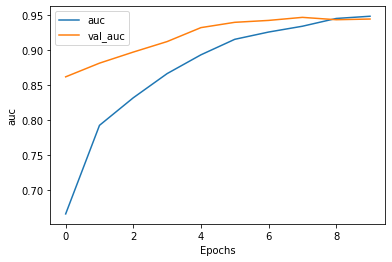

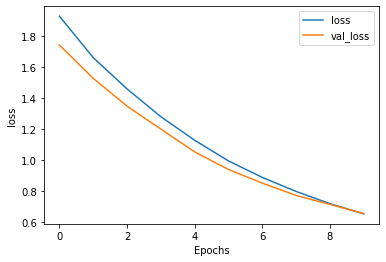

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc")  
plot_graphs(history, "loss")

In [11]:
scores_RNN = model.evaluate(val_dataset)

31/31 [==============================] - 0s 16ms/step - loss: 0.6554 - auc: 0.9442


### LSTM

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=wd)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=wd)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
%%time
num_epochs = 10
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/10
124/124 [==============================] - 6s 46ms/step - loss: 6.1928 - auc_1: 0.5306 - val_loss: 5.3438 - val_auc_1: 0.8695
Epoch 2/10
124/124 [==============================] - 5s 37ms/step - loss: 4.7470 - auc_1: 0.6865 - val_loss: 4.1382 - val_auc_1: 0.8841
Epoch 3/10
124/124 [==============================] - 5s 37ms/step - loss: 3.6619 - auc_1: 0.8232 - val_loss: 3.1663 - val_auc_1: 0.9214
Epoch 4/10
124/124 [==============================] - 5s 37ms/step - loss: 2.7935 - auc_1: 0.9208 - val_loss: 2.4443 - val_auc_1: 0.9467
Epoch 5/10
124/124 [==============================] - 5s 38ms/step - loss: 2.1641 - auc_1: 0.9506 - val_loss: 1.9279 - val_auc_1: 0.9459
Epoch 6/10
124/124 [==============================] - 5s 38ms/step - loss: 1.7009 - auc_1: 0.9525 - val_loss: 1.5388 - val_auc_1: 0.9437
Epoch 7/10
124/124 [==============================] - 5s 38ms/step - loss: 1.3751 - auc_1: 0.9452 - val_loss: 1.2461 - val_auc_1: 0.9482
Epoch 8/10
124/124 [=====================

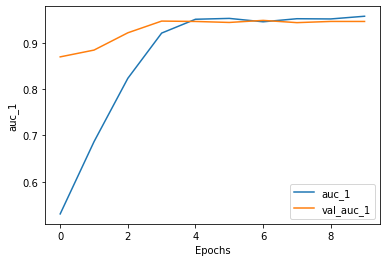

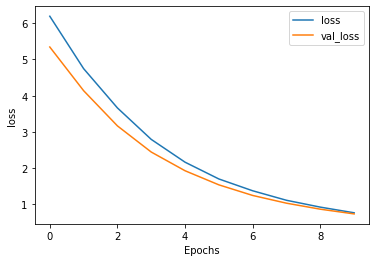

In [14]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_1")  
plot_graphs(history, "loss")

In [15]:
scores_LSTM = model.evaluate(val_dataset)

31/31 [==============================] - 0s 14ms/step - loss: 0.7366 - auc_1: 0.9459


### GRU

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, return_sequences=True, kernel_regularizer=wd),
    tf.keras.layers.GRU(32, kernel_regularizer=wd),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [17]:
%%time
num_epochs = 10
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/10
124/124 [==============================] - 3s 28ms/step - loss: 2.9678 - auc_2: 0.5575 - val_loss: 2.5718 - val_auc_2: 0.8757
Epoch 2/10
124/124 [==============================] - 3s 24ms/step - loss: 2.2742 - auc_2: 0.7208 - val_loss: 2.0178 - val_auc_2: 0.8762
Epoch 3/10
124/124 [==============================] - 3s 24ms/step - loss: 1.8491 - auc_2: 0.8081 - val_loss: 1.6490 - val_auc_2: 0.8913
Epoch 4/10
124/124 [==============================] - 3s 24ms/step - loss: 1.5169 - auc_2: 0.8489 - val_loss: 1.3609 - val_auc_2: 0.9023
Epoch 5/10
124/124 [==============================] - 3s 24ms/step - loss: 1.2501 - auc_2: 0.8801 - val_loss: 1.1273 - val_auc_2: 0.9125
Epoch 6/10
124/124 [==============================] - 3s 24ms/step - loss: 1.0398 - auc_2: 0.8975 - val_loss: 0.9431 - val_auc_2: 0.9235
Epoch 7/10
124/124 [==============================] - 3s 24ms/step - loss: 0.8682 - auc_2: 0.9149 - val_loss: 0.7963 - val_auc_2: 0.9331
Epoch 8/10
124/124 [=====================

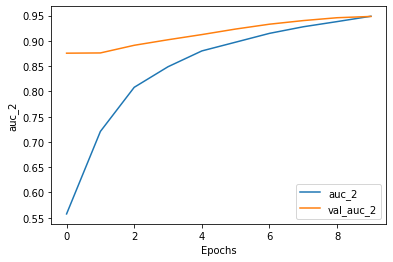

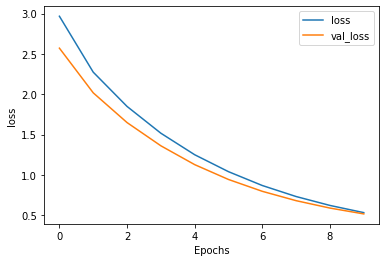

In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_2")  
plot_graphs(history, "loss")

In [19]:
scores_GRU = model.evaluate(val_dataset)

31/31 [==============================] - 0s 9ms/step - loss: 0.5161 - auc_2: 0.9484


Для сравнения результатов работы трех сетей использовались одинаковые классификаторы. Также одинаковое количество рекуррентных слоев и одинаковое количество ячеек в слоях.

In [20]:
scores_RNN

[0.6553688645362854, 0.9442093968391418]

In [21]:
scores_LSTM

[0.7366243004798889, 0.9458913803100586]

In [22]:
scores_GRU

[0.5160790085792542, 0.9483761191368103]

In [ ]:
Все три сети быстро переобучились, лучшее качество показала сеть GRU.